In [56]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import torch.nn.functional as F
from torchsummary import summary
import torchvision.datasets as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from utils import AverageMeter, ProgressMeter
from PIL import Image

In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.conv4 = nn.Conv2d(128, 128, (3, 3))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6272, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        batch, C, H, W = x.shape
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(batch, -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
            Conv2d-2           [-1, 64, 72, 72]          18,496
            Conv2d-3          [-1, 128, 34, 34]          73,856
            Conv2d-4          [-1, 128, 15, 15]         147,584
           Dropout-5                 [-1, 6272]               0
            Linear-6                  [-1, 512]       3,211,776
            Linear-7                    [-1, 1]             513
Total params: 3,453,121
Trainable params: 3,453,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.28
Params size (MB): 13.17
Estimated Total Size (MB): 22.71
----------------------------------------------------------------


In [60]:
train_transforms = transforms.Compose([transforms.RandomAffine(40, translate=(0, 0.3), scale=(0.8, 1.2), shear=(-30, 30), resample=Image.NEAREST),
#                                        transforms.RandomRotation(40),
#                                        transforms.RandomAffine(degrees=0, scale=(0.2, 0.3)),
#                                        transforms.RandomAffine(degrees=0, shear=(0.2, 0.2)),
                                       transforms.Resize((150, 150)),
                                       transforms.RandomHorizontalFlip(), 
#                                        transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       ])
test_transforms = transforms.Compose([transforms.ToTensor()])

In [61]:
train_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/train"
train_data = data.ImageFolder(train_dir, train_transforms)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=10)

In [62]:
print(train_data)

Dataset ImageFolder
    Number of datapoints: 2000
    Root Location: /data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/train
    Transforms (if any): Compose(
                             RandomAffine(degrees=(-40, 40), translate=(0, 0.3), scale=(0.8, 1.2), shear=(-30, 30))
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [63]:
val_transforms = transforms.Compose([transforms.Resize((150, 150)),                                
                                     transforms.ToTensor(),
                                    ])
validation_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/validation"
validation_data = data.ImageFolder(validation_dir, val_transforms)
val_loader = DataLoader(validation_data, batch_size=32)
print(validation_data)

Dataset ImageFolder
    Number of datapoints: 1000
    Root Location: /data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small/validation
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [64]:
criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # 更改了一下alpha

In [65]:
def train(model, train_loader, device, criteria, optimizer):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(train_loader), losses, accuracy)
    model.train()
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device).float().view(-1, 1)
        output = model(input)
        loss = criteria(output, target)
        losses.update(loss.item(), input.size(0))
        pre = output > 0.5
        predict = torch.zeros_like(pre).float()
        predict[pre] = 1.0
        correct = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
        accuracy.update(correct, input.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            progress.pr2int(i)
    return losses.avg, accuracy.avg

In [66]:
def evaluate(model, val_loader, device, criteria):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(val_loader), losses, accuracy)
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device).float().view(-1, 1)
            output = model(input)
            loss = criteria(output, target)
            losses.update(loss.item(), input.size(0))
            pre = output > 0.5
            predict = torch.zeros_like(pre).float()
            predict[pre] = 1.0
            acc = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
            accuracy.update(acc, input.size(0))
        return losses.avg, accuracy.avg

In [67]:
train_loss = []
train_acc = []
val_losses = []
val_acces = []
for i in range(100):
    print("Epoch: ", i)
    loss, acc = train(model, train_loader, device, criteria, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, device, criteria)
    print("val loss: {}, val acc: {}".format(val_loss, val_acc))
    train_loss.append(loss)
    train_acc.append(acc)
    val_losses.append(val_loss)
    val_acces.append(val_acc)

Epoch:  0
[ 0/63]	Loss 6.9389e-01 (6.9389e-01)	Acc   0.50 (  0.50)
[10/63]	Loss 6.9461e-01 (6.9394e-01)	Acc   0.47 (  0.49)
[20/63]	Loss 6.9110e-01 (6.9327e-01)	Acc   0.56 (  0.51)
[30/63]	Loss 6.8789e-01 (6.9324e-01)	Acc   0.66 (  0.51)
[40/63]	Loss 6.9566e-01 (6.9318e-01)	Acc   0.44 (  0.51)
[50/63]	Loss 6.9408e-01 (6.9331e-01)	Acc   0.47 (  0.50)
[60/63]	Loss 6.9838e-01 (6.9346e-01)	Acc   0.38 (  0.50)
val loss: 0.6930194759368896, val acc: 0.5
Epoch:  1
[ 0/63]	Loss 6.9112e-01 (6.9112e-01)	Acc   0.53 (  0.53)
[10/63]	Loss 6.8992e-01 (6.9247e-01)	Acc   0.56 (  0.54)
[20/63]	Loss 6.9031e-01 (6.9316e-01)	Acc   0.56 (  0.51)
[30/63]	Loss 6.9251e-01 (6.9297e-01)	Acc   0.53 (  0.52)
[40/63]	Loss 6.9055e-01 (6.9294e-01)	Acc   0.59 (  0.51)
[50/63]	Loss 6.9239e-01 (6.9294e-01)	Acc   0.44 (  0.52)
[60/63]	Loss 6.9257e-01 (6.9269e-01)	Acc   0.50 (  0.52)
val loss: 0.6916646461486816, val acc: 0.501
Epoch:  2
[ 0/63]	Loss 6.9255e-01 (6.9255e-01)	Acc   0.53 (  0.53)
[10/63]	Loss 6.9246e-01 (6.

[20/63]	Loss 6.3630e-01 (6.5291e-01)	Acc   0.62 (  0.64)
[30/63]	Loss 6.1324e-01 (6.5124e-01)	Acc   0.66 (  0.64)
[40/63]	Loss 5.3050e-01 (6.4716e-01)	Acc   0.78 (  0.64)
[50/63]	Loss 6.0258e-01 (6.4261e-01)	Acc   0.72 (  0.64)
[60/63]	Loss 6.3825e-01 (6.3906e-01)	Acc   0.62 (  0.65)
val loss: 0.6222067289352416, val acc: 0.649
Epoch:  19
[ 0/63]	Loss 6.9877e-01 (6.9877e-01)	Acc   0.50 (  0.50)
[10/63]	Loss 5.9669e-01 (6.3908e-01)	Acc   0.69 (  0.61)
[20/63]	Loss 6.4531e-01 (6.3471e-01)	Acc   0.59 (  0.63)
[30/63]	Loss 6.4991e-01 (6.3857e-01)	Acc   0.62 (  0.63)
[40/63]	Loss 5.7542e-01 (6.3171e-01)	Acc   0.75 (  0.65)
[50/63]	Loss 5.4180e-01 (6.2955e-01)	Acc   0.78 (  0.65)
[60/63]	Loss 6.0098e-01 (6.3479e-01)	Acc   0.72 (  0.64)
val loss: 0.6139648337364196, val acc: 0.665
Epoch:  20
[ 0/63]	Loss 7.5199e-01 (7.5199e-01)	Acc   0.59 (  0.59)
[10/63]	Loss 6.0485e-01 (6.3433e-01)	Acc   0.66 (  0.65)
[20/63]	Loss 7.0809e-01 (6.3938e-01)	Acc   0.59 (  0.65)
[30/63]	Loss 5.4641e-01 (6.2523e-

[40/63]	Loss 5.5512e-01 (5.6965e-01)	Acc   0.69 (  0.70)
[50/63]	Loss 6.8640e-01 (5.7321e-01)	Acc   0.72 (  0.70)
[60/63]	Loss 5.8971e-01 (5.7416e-01)	Acc   0.69 (  0.70)
val loss: 0.5943181004524231, val acc: 0.682
Epoch:  37
[ 0/63]	Loss 7.5142e-01 (7.5142e-01)	Acc   0.59 (  0.59)
[10/63]	Loss 6.3968e-01 (6.1060e-01)	Acc   0.59 (  0.67)
[20/63]	Loss 5.0539e-01 (5.8550e-01)	Acc   0.72 (  0.68)
[30/63]	Loss 5.5585e-01 (5.7821e-01)	Acc   0.69 (  0.69)
[40/63]	Loss 5.9860e-01 (5.8177e-01)	Acc   0.66 (  0.69)
[50/63]	Loss 4.2631e-01 (5.7588e-01)	Acc   0.84 (  0.69)
[60/63]	Loss 5.9260e-01 (5.7690e-01)	Acc   0.69 (  0.69)
val loss: 0.5789500076770783, val acc: 0.708
Epoch:  38
[ 0/63]	Loss 6.1164e-01 (6.1164e-01)	Acc   0.69 (  0.69)
[10/63]	Loss 5.0657e-01 (5.5979e-01)	Acc   0.72 (  0.70)
[20/63]	Loss 6.0912e-01 (5.7096e-01)	Acc   0.75 (  0.70)
[30/63]	Loss 4.7380e-01 (5.7029e-01)	Acc   0.78 (  0.70)
[40/63]	Loss 6.7492e-01 (5.7016e-01)	Acc   0.59 (  0.70)
[50/63]	Loss 4.8056e-01 (5.6751e-

[60/63]	Loss 4.5180e-01 (5.3409e-01)	Acc   0.81 (  0.73)
val loss: 0.543699764251709, val acc: 0.721
Epoch:  55
[ 0/63]	Loss 3.9859e-01 (3.9859e-01)	Acc   0.91 (  0.91)
[10/63]	Loss 5.0659e-01 (5.2599e-01)	Acc   0.69 (  0.73)
[20/63]	Loss 4.6200e-01 (5.3888e-01)	Acc   0.81 (  0.72)
[30/63]	Loss 6.9014e-01 (5.4488e-01)	Acc   0.56 (  0.71)
[40/63]	Loss 5.8214e-01 (5.4178e-01)	Acc   0.66 (  0.72)
[50/63]	Loss 5.5399e-01 (5.3350e-01)	Acc   0.69 (  0.73)
[60/63]	Loss 6.3178e-01 (5.3169e-01)	Acc   0.56 (  0.73)
val loss: 0.5466386337280273, val acc: 0.724
Epoch:  56
[ 0/63]	Loss 6.5640e-01 (6.5640e-01)	Acc   0.78 (  0.78)
[10/63]	Loss 4.8071e-01 (5.2552e-01)	Acc   0.78 (  0.76)
[20/63]	Loss 5.7139e-01 (5.5285e-01)	Acc   0.75 (  0.73)
[30/63]	Loss 5.0453e-01 (5.3646e-01)	Acc   0.75 (  0.74)
[40/63]	Loss 5.2321e-01 (5.3627e-01)	Acc   0.78 (  0.74)
[50/63]	Loss 5.8659e-01 (5.3699e-01)	Acc   0.62 (  0.73)
[60/63]	Loss 4.6281e-01 (5.4082e-01)	Acc   0.78 (  0.73)
val loss: 0.5333700113296509, val 

val loss: 0.5325301241874695, val acc: 0.732
Epoch:  73
[ 0/63]	Loss 4.3883e-01 (4.3883e-01)	Acc   0.81 (  0.81)
[10/63]	Loss 5.4364e-01 (4.9725e-01)	Acc   0.66 (  0.73)
[20/63]	Loss 5.7995e-01 (4.8743e-01)	Acc   0.69 (  0.75)
[30/63]	Loss 5.1090e-01 (5.0975e-01)	Acc   0.72 (  0.73)
[40/63]	Loss 4.2732e-01 (5.0156e-01)	Acc   0.84 (  0.74)
[50/63]	Loss 4.4364e-01 (5.0938e-01)	Acc   0.88 (  0.74)
[60/63]	Loss 4.4765e-01 (5.0892e-01)	Acc   0.78 (  0.74)
val loss: 0.5205993385314941, val acc: 0.734
Epoch:  74
[ 0/63]	Loss 5.1856e-01 (5.1856e-01)	Acc   0.72 (  0.72)
[10/63]	Loss 5.3660e-01 (5.1419e-01)	Acc   0.69 (  0.76)
[20/63]	Loss 4.7488e-01 (5.0906e-01)	Acc   0.78 (  0.75)
[30/63]	Loss 5.2882e-01 (5.1396e-01)	Acc   0.75 (  0.76)
[40/63]	Loss 4.6884e-01 (5.0755e-01)	Acc   0.84 (  0.76)
[50/63]	Loss 4.9407e-01 (5.1198e-01)	Acc   0.66 (  0.75)
[60/63]	Loss 4.9757e-01 (5.1108e-01)	Acc   0.75 (  0.75)
val loss: 0.5214246082305908, val acc: 0.737
Epoch:  75
[ 0/63]	Loss 4.9472e-01 (4.9472e-0

[ 0/63]	Loss 3.8788e-01 (3.8788e-01)	Acc   0.88 (  0.88)
[10/63]	Loss 4.5801e-01 (4.9467e-01)	Acc   0.78 (  0.76)
[20/63]	Loss 7.1945e-01 (4.8276e-01)	Acc   0.66 (  0.77)
[30/63]	Loss 4.3575e-01 (4.9154e-01)	Acc   0.78 (  0.77)
[40/63]	Loss 4.2080e-01 (4.9233e-01)	Acc   0.88 (  0.77)
[50/63]	Loss 4.9342e-01 (4.9787e-01)	Acc   0.75 (  0.77)
[60/63]	Loss 4.4280e-01 (4.9371e-01)	Acc   0.81 (  0.77)
val loss: 0.5037523717880249, val acc: 0.748
Epoch:  92
[ 0/63]	Loss 3.9083e-01 (3.9083e-01)	Acc   0.72 (  0.72)
[10/63]	Loss 4.3534e-01 (4.6290e-01)	Acc   0.78 (  0.77)
[20/63]	Loss 4.3312e-01 (4.7688e-01)	Acc   0.81 (  0.76)
[30/63]	Loss 4.9393e-01 (4.7373e-01)	Acc   0.75 (  0.77)
[40/63]	Loss 4.6610e-01 (4.8499e-01)	Acc   0.78 (  0.76)
[50/63]	Loss 3.0205e-01 (4.8730e-01)	Acc   0.91 (  0.76)
[60/63]	Loss 5.0245e-01 (4.9206e-01)	Acc   0.66 (  0.75)
val loss: 0.49711118221282957, val acc: 0.751
Epoch:  93
[ 0/63]	Loss 5.1293e-01 (5.1293e-01)	Acc   0.84 (  0.84)
[10/63]	Loss 5.5071e-01 (4.9989e

In [53]:
epoches = range(1, len(train_acc) + 1)

In [54]:
import matplotlib.pyplot as plt

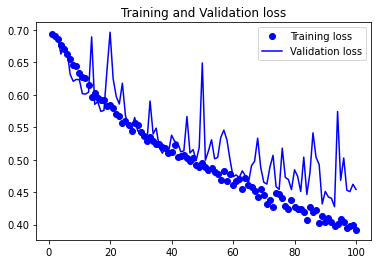

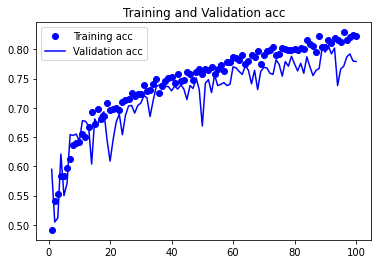

In [55]:
plt.plot(epoches, train_loss, 'bo', label="Training loss")
plt.plot(epoches, val_losses, 'b', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.figure()
plt.plot(epoches, train_acc, 'bo', label="Training acc")
plt.plot(epoches, val_acces, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.show()

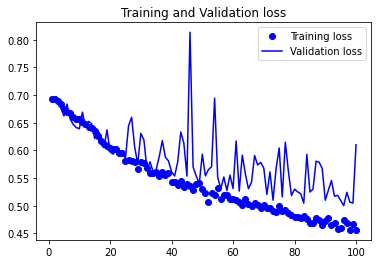

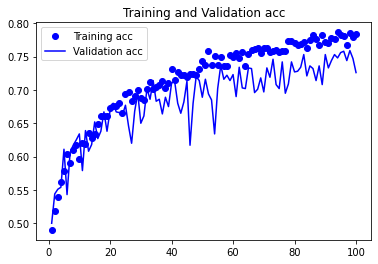

In [19]:
plt.plot(epoches, train_loss, 'bo', label="Training loss")
plt.plot(epoches, val_losses, 'b', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.figure()
plt.plot(epoches, train_acc, 'bo', label="Training acc")
plt.plot(epoches, val_acces, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.show()